<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br><h2>A1 : Social Media Analytics Project</h2>
<h4>Jaeah Choi</h4><br>
Hult International Business School<br>
Social Media Analytics for Business Intelligence<br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

# 1. Introduction

 Nowadays, new technologies have been affected many parts of our lives. For example, it helps people work from home or take a virtual class from their home country in a pandemic situation, and a flying car, self-driving car, and smart city are right around the corner. Electric vehicles are a prime example of introducing new technologies into our lives. Electric vehicles are gaining a lot of popularity, and the environmental issue has led the automobile market to develop electronic vehicles. As many automakers have recently released their latest versions of electric cars, I analyze people’s thoughts using Twitter. This report aims to understand the trend of people’s thinking about electric vehicles, especially six-vehicle brands: Tesla, Nissan, Kia, Chevrolet, Hyundai, and Toyota. In addition, based on top keywords from each brand, insights will be suggested in the report. 

# 2. Data Analysis code
## 1) Connect Twitter, Import & Clean Data 

As a starter, I have imported 8000 Twitter to observe people’s opinions about electric vehicles. By using the Tweepy package, I was able to connect to Twitter search API. After importing the data, the essential data such as text, retweets, favorites, users put into data frame type for analysis. The reason to import 8,000 data is overlapping advertising tweets. Considering that redundancy advertising will affect the calculation of keywords, I conducted data cleaning using the ‘drop_duplicates’ function. Therefore, recent 7973 tweets were used to analyze electric vehicles. I filtered EV and car with stop words because it’s the topic and picked six brands based on google search.

In [1]:
#######################################
########   Import packages   ##########
#######################################

# Data & plot
import pandas as pd
import matplotlib.pyplot as plt

# Call Twitter
import tweepy as tw
import config_twitter_Jaeah # change it to yours

# Json, word clouds
import html
import json
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud


In [2]:
# establish Twitter API connection / # change it to yours
auth = tw.OAuthHandler(config_twitter_Jaeah.consumer_key, config_twitter_Jaeah.consumer_secret)
auth.set_access_token(config_twitter_Jaeah.access_token, config_twitter_Jaeah.access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

user = api.verify_credentials()

# To check connecting API
user

User(_api=<tweepy.api.API object at 0x000001706FE77A90>, _json={'id': 1356502369631043584, 'id_str': '1356502369631043584', 'name': 'Jaeah', 'screen_name': 'Jaeah52515667', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 0, 'listed_count': 0, 'created_at': 'Tue Feb 02 07:19:11 +0000 2021', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 0, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_image_url_https': 'https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png', 'profile_link_co

In [3]:
# function to establish an initial API connection, respecting the rate limit
def connect_api_client(): # Change it to yours
    auth = tw.OAuthHandler(config_twitter_Jaeah.consumer_key, config_twitter_Jaeah.consumer_secret)
    auth.set_access_token(config_twitter_Jaeah.access_token, config_twitter_Jaeah.access_token_secret)
    # https://docs.tweepy.org/en/stable/getting_started.html#api
    api = tw.API(auth, wait_on_rate_limit=True)
    try:
        # returns False if credentials could not be verified
        api.verify_credentials()
        user = api.verify_credentials()
        if not user:
            raise("Credentials could not be verified: Please check config.py")
        print(f"Connected to Twitter API as {user.name}")
    except Exception as e:
        raise e
    return api

api = connect_api_client()

Connected to Twitter API as Jaeah


In [4]:
# construct a search query

query = 'ev OR "EV" OR "Electric Vehicle" OR "electric vehicle" OR ' +\
            '"Electric Car" OR "electric car" -filter:retweets'

In [5]:
ntweets = 8000

tweets = [tweet._json for tweet in tw.Cursor(api.search, q=query, lang="en", tweet_mode='extended').items(ntweets)]

In [6]:
# save tweets data to json file
file_out = f"raw_tweet_data_{ntweets}.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(tweets, indent=2))

In [7]:
# First collect the data in json-file; specify file name here (adjust the number as queried)
fjson = 'raw_tweet_data_8000.json'
# read json file with tweets data
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

8000

In [8]:
# Set the data as dataframe type

df_tweets = pd.DataFrame([t['full_text'] for t in data], columns=['text'])

# add selected columns from tweet data fields
df_tweets['retweets'] = [t['retweet_count'] for t in data]
df_tweets['favorites'] = [t['favorite_count'] for t in data]
df_tweets['user'] = [t['user']['screen_name'] for t in data]

# Check the dataframe df_tweets
#df_tweets

In [9]:
# Delete duplicated data

df_tweets_clean = df_tweets.drop_duplicates('text', keep = 'last')

In [10]:
df_tweets_clean.count()

text         7973
retweets     7973
favorites    7973
user         7973
dtype: int64

In [11]:
# text cleaning function: see prior class modules
stop_words = set(stopwords.words('english'))

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and
               (w not in string.punctuation) and (w.isalnum()) and
               (w not in "ev") and (w not in "EV") and (w not in "car") and
               (w not in "Electric") and (w not in "electric")]
    
    # return clean string
    return ' '.join(wt_filt)


In [12]:
# add clean text col
df_tweets_clean['text_clean'] = df_tweets_clean['text'].apply(text_cleanup)
df_tweets_clean

<ipython-input-12-adbb139075cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_clean['text_clean'] = df_tweets_clean['text'].apply(text_cleanup)


,text,retweets,favorites,user,text_clean
0,@El_DoN_EV @zooko That would be an infinite lo...,0,0,AppsCrafter,zooko would infinite loop
1,$BB has a patent on a wallet that literally au...,0,0,acerunner_kj,bb patent wallet literally automatically pays ...
2,There remains no evidence of a coherent bull c...,0,1,PBRStreetGang7,remains evidence coherent bull case last place...
3,"@EricjEpps 🤣🤣 omg that’s so funny, I wish my p...",0,0,Heiressalana,ericjepps omg thats funny wish parents like si...
4,"#ActOnClimate Business Matters \nSolar panels,...",0,0,NorthKestevenDC,actonclimate business matters solar panels cha...
...,...,...,...,...,...
7995,"@OlaElectric Best wishes, hope ola become the ...",0,1,bw6PmpZQsuZFvbn,olaelectric best wishes hope ola become world ...
7996,@traderjrae seems they move a 'Bolt' too. http...,0,0,noalpha_allbeta,traderjrae seems move
7997,GM expands Ultium Charge 360 program to commer...,0,0,BcabaNetwork,gm expands ultium charge 360 program commercia...
7998,Remembering our fantastic photo shoot in Londo...,0,2,RBWClassicElec,remembering fantastic photo shoot london visit...


In [13]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_tweets_clean['polarity'] = df_tweets_clean['text_clean'].apply(sentim_polarity)
df_tweets_clean['subjectivity'] = df_tweets_clean['text_clean'].apply(sentim_subject)
df_tweets_clean.head(10)

<ipython-input-13-bea2882c8c2a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_clean['polarity'] = df_tweets_clean['text_clean'].apply(sentim_polarity)
<ipython-input-13-bea2882c8c2a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_clean['subjectivity'] = df_tweets_clean['text_clean'].apply(sentim_subject)


,text,retweets,favorites,user,text_clean,polarity,subjectivity
0,@El_DoN_EV @zooko That would be an infinite lo...,0,0,AppsCrafter,zooko would infinite loop,0.000000,0.000000
1,$BB has a patent on a wallet that literally au...,0,0,acerunner_kj,bb patent wallet literally automatically pays ...,0.000000,0.000000
2,There remains no evidence of a coherent bull c...,0,1,PBRStreetGang7,remains evidence coherent bull case last place...,0.050000,0.316667
3,"@EricjEpps 🤣🤣 omg that’s so funny, I wish my p...",0,0,Heiressalana,ericjepps omg thats funny wish parents like si...,0.162500,0.725000
4,"#ActOnClimate Business Matters \nSolar panels,...",0,0,NorthKestevenDC,actonclimate business matters solar panels cha...,0.000000,0.000000
5,@LauraForczyk The bikes with trailers for kids...,0,0,romn8tr,lauraforczyk bikes trailers kids come mind dis...,0.125000,0.644444
6,Required early voting hours in existing electi...,0,1,alexazura,required early voting hours existing election ...,-0.100000,0.350000
7,Thinking about an electric vehicle? There is a...,0,0,saanich,thinking vehicle network charging stations reg...,-0.300000,0.500000
8,@learninglibs2 @GrwnAssKid2 @PalmerReport Well...,0,1,AcornSandwich,learninglibs2 grwnasskid2 palmerreport well yo...,0.105357,0.292857
9,Check out this Video on the WallBox Pulsar Plu...,0,0,evannex_com,check video wallbox pulsar plus home office ch...,0.400000,0.400000


In [14]:
# define the list of brands to analyze, consistent with the search topic
#  for which the tweets were collected
brands = ['tesla', 'nissan', 'kia', 'chevrolet', 'hyundai', 'toyota']

## 2) Overall analysis

  From 7973 data, Tesla mentioned overwhelmingly 607 times with electric vehicles than the other five brands. The remaining brands were mentioned less than 50 times on people’s tweets, and Chevrolet and Nissan follow after Tesla. In overall people’s tweets, I filtered the top 20 positive and negative polarities to observe people's words with electric vehicles. For example, words ‘best’, ‘impressive,’ ‘learning’ commented on people’s tweets from top 20 positive polarity texts. Conversely, words ‘hate’, ‘horrible,’ ‘worst’ show after filtering the top 20 negative polarity texts. From the average_sentiment table, the average sentiment from all brands is positive, which means people wrote the brands with positive words. Kia shows the highest, and Toyota shows the lowest average sentiment.

In [15]:
# Counting tweets mentioned each brand

i = 0
count_tesla = 0
count_nissan = 0
count_kia = 0
count_chevrolet = 0
count_hyundai = 0
count_toyota = 0

while i < len(df_tweets_clean) :
    if 'tesla' in df_tweets_clean.iloc[i,4] :
        count_tesla += 1
        i += 1
    
    elif 'nissan' in df_tweets_clean.iloc[i, 4]:
        count_nissan += 1
        i += 1
        
    elif 'kia' in df_tweets_clean.iloc[i, 4] : 
        count_kia += 1
        i += 1
        
    elif 'chevrolet' in df_tweets_clean.iloc[i, 4] :
        count_chevrolet += 1
        i += 1
    
    elif 'hyundai' in df_tweets_clean.iloc[i, 4] :
        count_hyundai += 1
        i += 1
    
    elif 'toyota' in df_tweets_clean.iloc[i, 4] :
        count_toyota += 1
        i += 1
        
    else :
        i += 1
        


In [16]:
# put into Data Frame
br_count = pd.DataFrame([['tesla', count_tesla], ['nissan', count_nissan],
                         ['kia', count_kia], ['chevrolet', count_chevrolet],
                         ['hyundai', count_hyundai], ['toyota', count_toyota]],
                        columns = ['brand', 'count'])

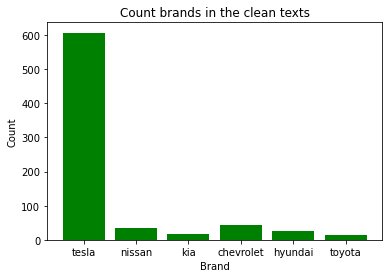

In [17]:
# ploting graph
plt.bar(br_count['brand'], br_count['count'], color = 'green')

plt.xlabel("Brand")
plt.ylabel("Count")
plt.title("Count brands in the clean texts")
plt.show()

In [18]:
br_count.sort_values(by = 'count', ascending = False)

,brand,count
0,tesla,607
3,chevrolet,43
1,nissan,35
4,hyundai,27
2,kia,16
5,toyota,14


<AxesSubplot:ylabel='keyword'>

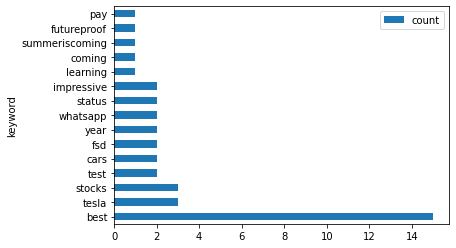

In [21]:
# Overall positive polarity
df_polarity = df_tweets_clean.sort_values(by='polarity', ascending=False).head(20)

# top 20 polarity 
polarity_20 = ' '.join(df_polarity['text_clean'])

# Bar chat for top 15 words from word clouds
kwords_polarity = WordCloud().process_text(polarity_20)

# put into dataframe
df_kwords_polarity = pd.DataFrame(list(kwords_polarity.items()), columns=['keyword', 'count']).set_index('keyword')

# ploting
df_kwords_polarity.sort_values(by='count', ascending=False).head(15).plot.barh()

<AxesSubplot:ylabel='keyword'>

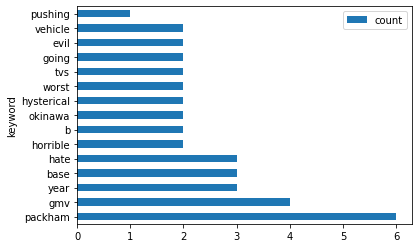

In [22]:
# Overall negative polarity
df_polarity_neg = df_tweets_clean.sort_values(by='polarity', ascending=True).head(20)

# negative 20 polarity 
polarity_neg_20 = ' '.join(df_polarity_neg['text_clean'])

# Bar chat for top 15 words from word clouds
kwords_polarity_neg = WordCloud().process_text(polarity_neg_20)

# put into dataframe
df_kwords_polarity_neg = pd.DataFrame(list(kwords_polarity_neg.items()),
                                      columns=['keyword', 'count']).set_index('keyword')

# ploting
df_kwords_polarity_neg.sort_values(by='count', ascending=False).head(15).plot.barh()

In [19]:
# Putting brand data frame
df_brands = pd.DataFrame(brands, columns=['brand'])

# function to compute average sentiment of tweets mentioning a given brand
def brand_sentiment(b):
    return df_tweets_clean[df_tweets_clean['text_clean'].str.contains(b)]['polarity'].mean()

In [20]:
# brand sentiment comparison
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands

,brand,average_sentiment
0,tesla,0.107206
1,nissan,0.163187
2,kia,0.237109
3,chevrolet,0.087466
4,hyundai,0.147702
5,toyota,0.015430


## 3) Retweets & Favorites analysis
 Many favorites and retweets on Twitter can be indicators that many people have seen the posts. Therefore, to analyze what people saw in many tweets, I filtered out the top 100 tweets of favourites and retweets. Then, I called the top 15 words from each.
 
 From the top 100 retweets posts, the highest retweet number is 282. In the texts, charging posted a lot with electric vehicles. Since the car needs the power to operate, charging station or power company, tata power, as the top in the bar graph. Moreover, leading electric vehicle company, Tesla, mentioned many times, and NIO Chinese car company also posted on people’s tweets. The interesting keyword is ‘sponsored post’. I assume people retweet a lot of advertising posts.
 
 The highest favorites number of a post is 1070. Similar to retweet top 100, the word charge or charging station shows a lot. The impressive word from HPCL set. The HPCL is an oil and gas corporation company in India. The word shows in keywords because Tata power, an Indian power company, set up EV charging stations at HPCL petrol pumps. This case is an example of people are sharing and following their thought of the news on tweets.


In [23]:
# most retweeted content
df_retweets = df_tweets_clean.sort_values(by='retweets', ascending=False).head(100)

# Top 10 retweets numbers
df_retweets.retweets.head(10)

3282    282
6462    202
4501    109
3905     77
6797     76
3857     64
6942     61
4350     54
4521     53
2549     51
Name: retweets, dtype: int64

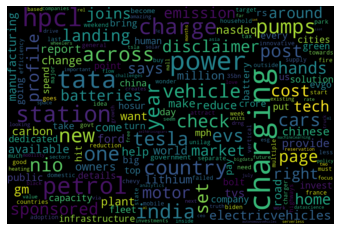

In [24]:
# top 100 retweet word clouds
retweet_100 = ' '.join(df_retweets['text_clean'])

wc_retweet = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(retweet_100)
plt.axis("off")
plt.imshow(wc_retweet, interpolation="bilinear")
plt.show()

<AxesSubplot:ylabel='keyword'>

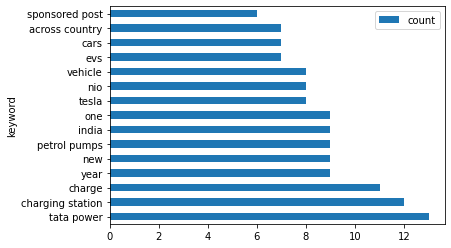

In [25]:
# Bar chat for top 20 words from word clouds

kwords_retweet = WordCloud().process_text(retweet_100)

# put into dataframe
df_kwords_retweet = pd.DataFrame(list(kwords_retweet.items()), columns=['keyword', 'count']).set_index('keyword')

# ploting
df_kwords_retweet.sort_values(by='count', ascending=False).head(15).plot.barh()

In [26]:
# most retweeted content
df_fav = df_tweets_clean.sort_values(by='favorites', ascending=False).head(100)

# Top 10 favorites numbers
df_fav.favorites.head(10)

3282    1070
6462     920
2799     457
6051     431
3857     402
2720     285
3931     284
5122     239
6942     209
4532     202
Name: favorites, dtype: int64

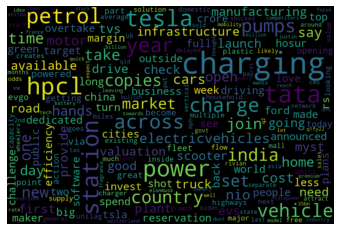

In [27]:
# top 100 favorites word clouds
fav_100 = ' '.join(df_fav['text_clean'])

wc_retweet = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(fav_100)
plt.axis("off")
plt.imshow(wc_retweet, interpolation="bilinear")
plt.show()

<AxesSubplot:ylabel='keyword'>

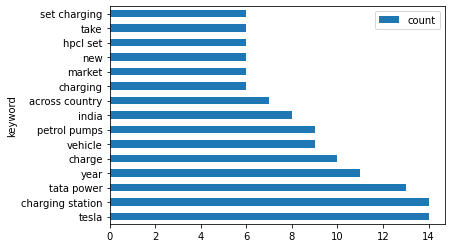

In [28]:
# Bar chat for top 20 words from word clouds
kwords_fav = WordCloud().process_text(fav_100)

# put into dataframe
df_kwords_fav = pd.DataFrame(list(kwords_fav.items()), columns=['keyword', 'count']).set_index('keyword')

# ploting
df_kwords_fav.sort_values(by='count', ascending=False).head(15).plot.barh()

## 4) Analysis by brands
Analyzing Twitter by the brand can reveal the latest people's thoughts on the company and show many things, including people's opinions on the overall automobile market and the latest issues of related brands. It is also a good indicator of people's needs for startup companies that are newly starting electric vehicle businesses. After filtering each brand, I plotted word clouds. Also, the bar graph shows the top 15 keywords from each brands word cloud.

In [29]:
# combine all text for a specific brand
def brand_all_text(brand):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_tweets_clean[df_tweets_clean['text_clean'].str.contains(brand)]['text_clean'])

In [30]:
# top keywords counts function
def top_count (brand) :
    key_words_brand = WordCloud().process_text(brand_all_text(brand))
    df_key_words_brand = pd.DataFrame(list(key_words_brand.items()), columns = ['keyword', 'count']).set_index('keyword')

    df_key_words_brand.sort_values(by='count', ascending= False).head(15).plot.barh()


### (1) Tesla

 Based on Tesla results, Elon Musk, the founder of the company, mentioned a lot. I assume Elon Musk uploaded or retweet Tesla products or news. Also, people said him on their posts since he is one of the influencers. Since the new product Cybertruck will expect to release in late 2021, Cyber truck, new, market words are in keywords. Besides, comparing Tesla Cybertruck and Ford products has been posted many times. Charging and battery also show in the results because of people’s concern about electric cars.

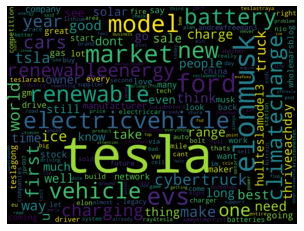

In [31]:
wc = WordCloud(width=2000, height=1500, max_font_size=350, collocations=False).generate(brand_all_text('tesla'))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

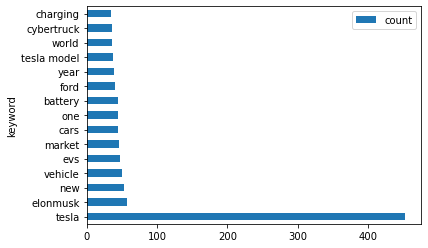

In [32]:
top_count('tesla')

### (2) Nissan

 The EV car model from Nissan, Nissan leaf, shows the highest. Because of discount Nissan brand for NHS staff, NHS UK shows on the results. Based on research, NHS staff can save up to 29% at over 50 dealerships on the Nissan brand. I guess people from NHS posted with the information or the Nissan hashtag NHS UK for advertising. Competitors, GM and NIO, are in the keywords, and Niu, the electric scooter brand, also is in the keywords.

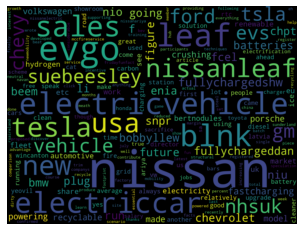

In [33]:
wc_nissan = WordCloud(width=2000, height=1500, max_font_size=350, collocations=False).generate(brand_all_text('nissan'))
plt.axis("off")
plt.imshow(wc_nissan, interpolation="bilinear")
plt.show()

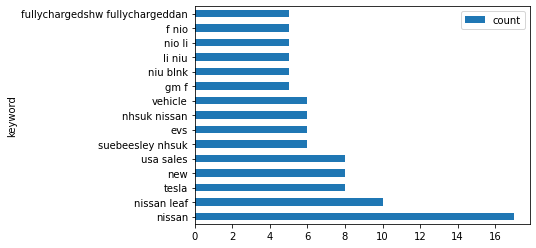

In [34]:
top_count('nissan')

### (3) Kia

The two Kia EV products, Soul and Niro, shows on the keywords list. In addition, the words ‘mr’ and ‘technology show on the list because of an app called ‘Kia product MR experience’. The competitor, Tesla, mentioned Kia. The Kia has the highest average sentiment result because positive words likes 'new', 'good','win', 'collecting' have posted with Kia brand.

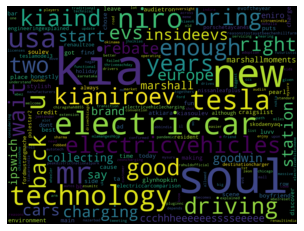

In [35]:
wc_kia = WordCloud(width=2000, height=1500, max_font_size=350, collocations=False).generate(brand_all_text('kia'))
plt.axis("off")
plt.imshow(wc_kia, interpolation="bilinear")
plt.show()

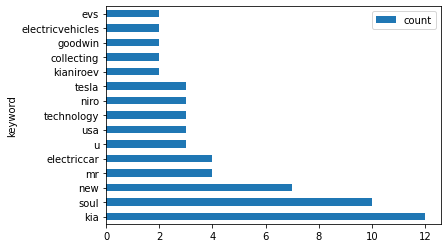

In [36]:
top_count('kia')

### (4) Chevrolet

 Recent accidents of fires on the Bolt products, fire show in the top keywords of Chevrolet. Because of the news that General Motors tells chevy Bolt owners to park outside, not indoors, the headline words of new are showing on the keywords. I guess recall is in the keywords because of battery defect. The words 'dont', 'fire', 'warn' might affect to reduce average sentiment score.

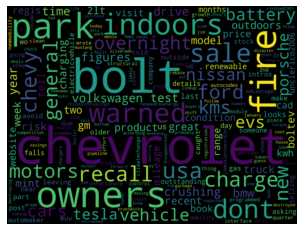

In [37]:
wc_chev = WordCloud(width=2000, height=1500, max_font_size=350, collocations=False).generate(brand_all_text('chevrolet'))
plt.axis("off")
plt.imshow(wc_chev, interpolation="bilinear")
plt.show()

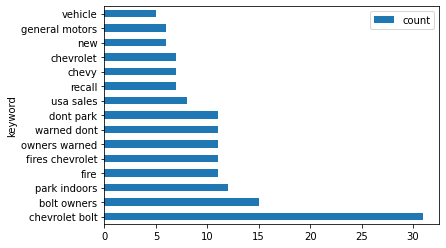

In [38]:
top_count('chevrolet')

### (5) Hyundai

 Ioniq 5, which expects to release in 2022, is interested in future customers with a price and how many miles to drive. Kona, another EV from Hyundai, posted on the tweets. Looking at Tesla and Toyota as keywords, one can see that people compare Hyundai products to two brands. The positive words 'new', 'need' used with the brand.

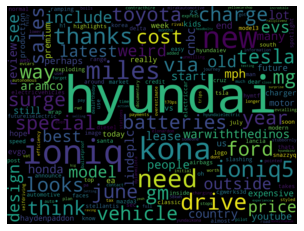

In [39]:
wc_hyundai = WordCloud(width=2000, height=1500, max_font_size=350, collocations=False).generate(brand_all_text('hyundai'))
plt.axis("off")
plt.imshow(wc_hyundai, interpolation="bilinear")
plt.show()

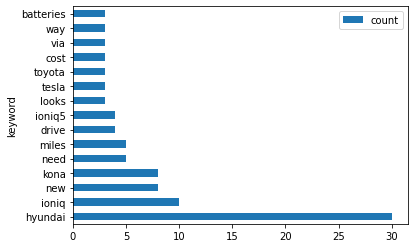

In [40]:
top_count('hyundai')

### (6) Toyota

Toyota is famous for its hybrid car Prius. Toyota was an early pioneer in electrification, but it has fallen behind its competitors, Tesla, GM, Honda, and Hyundai.  I guess all brands show into keywords because of falling behind the trends. Positive words used on people's tweet such as 'must','new','need'. However, the number of words used is low, so the average sentiment score is low even though the exact words are used.

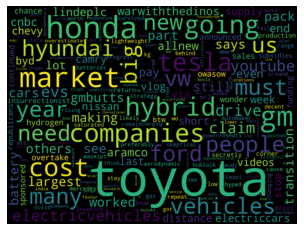

In [41]:
wc_toyota = WordCloud(width=2000, height=1500, max_font_size=350, collocations=False).generate(brand_all_text('toyota'))
plt.axis("off")
plt.imshow(wc_toyota, interpolation="bilinear")
plt.show()

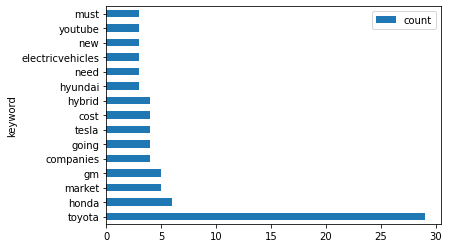

In [42]:
top_count('toyota')

## 6) Top infludencers

I think knowing influencer is important because new products can be advertised through influencer and affect the brand itself for many people. 

In [43]:
# users producing most retweeted content
df_tweets_clean.sort_values(by='retweets', ascending=False).head(20)['user']

3282           Naija_PR
6462         leslibless
4501        RealCalvinX
3905         Omkar_Raii
6797    SEESustainabil1
3857    LeenaManimekali
6942          SharpieDj
4350            CBSNews
4521           farmgeek
2549          simonahac
4461        SwarajyaMag
2720     JstInvestments
2799        Ajaya_buddy
1968            OKirume
1200       MrsG06951702
4951     Natalia01Mateo
1888          TataPower
167             MkBlyth
663            peysheld
1129            OKirume
Name: user, dtype: object

# 3. Conclusion

I analyzed people’s thinking of electric vehicles using Twitter. First, I did data cleaning before digging the analysis because there are the repeated contents for advertising. Due to being the leading company in the electric vehicle market, people mentioned Tesla significantly in 7939 tweets. The ‘best’,’ impressive’ etc. positive words are used in high polarity texts, while ‘hate’,’horrible’, and negative comments are posted on low polarity texts. All brand's average sentiments are positive, and Kia is the highest 0.237 and Toyota is the lowest 0.015. All brands show the positive word ‘new’ in their top keywords. Analyzing retweets and favorites top 100 entire contents can indicate what contents people like and what words have used. Also, investigating keywords by brands can assist the company in improving the brand via people’s feedback. For example, the Chevrolet token results show less favorable than other brands because of the fire on Bolt. Besides, Toyota has many competitors offering the keywords because of falling behind the trends. On the other hand, the rest of the brand’s tokens show with the brand’s EV products. To improve code and analysis in the future, I would like to delete topic words and the brand name on word clouds and keyword graphs. It helps pull out essential keywords. Also, increasing the tweeter size will give a different analysis point of view. Companies can prepare marketing to raise people's interest in products through witty advertising by analyzing people's tweets.  It will also draw attention by creating slogans with positive words about electric vehicles that people think, and prepare for what people consider when buying electric cars through tokens such as charging stations or batteries.

## 4.Reference
https://play.google.com/store/apps/details?id=com.kia.ProductMRExperience&hl=en_US&gl=US

https://insideevs.com/features/520721/tesla-cybertruck-surprises-expectations/

https://www.theverge.com/2021/4/19/22391738/toyota-electric-vehicle-strategy-bz4x-concept-subaru

https://www.engadget.com/gm-chevy-bolt-fire-warning-215322969.html